# 1. Defining a diffusion model with custom degradation function


In [16]:
!mkdir -p contents_custom

In [17]:
# From https://stackoverflow.com/questions/61058798/python-relative-import-in-jupyter-notebook
import os, sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
from src import funcs

In [18]:
from typing import Dict, Tuple

import random
import copy
import numpy as np
import torch
import torch.nn as nn
from accelerate import Accelerator
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid

In [19]:
# Set random seeds
torch.manual_seed(75016)
np.random.seed(75016)

In [20]:
def schedules(order: int, T: int, type: str) -> Dict[str, torch.Tensor]:
    """Returns order and schedule for each row/column in the image."""

    assert order == 1 or order == 2 or order == 3, "Order must be either 1 or 2"

    half_point = T // 2 - 1
    backward = list(range(13, -1, -1))
    forward = list(range(13 + 1, 28))
    index = []
    if order == 1:
        for i in range(half_point + 1):
            index.append(forward[i])
            index.append(backward[i])
        if T % 2 == 1:
            index.append(forward[half_point + 1])
    elif order == 2:
        for i in range(1, half_point + 2):
            index.append(backward[-i])
            index.append(forward[-i])
        if T % 2 == 1:
            index.append(forward[-half_point - 2])
    else:
        # Unique random order
        index = random.sample(range(28), 28)

    return {type: torch.tensor(index)}


def schedules_7(order: int, T: int, type: str) -> Dict[str, torch.Tensor]:
    """Returns order and schedule for each 4 wide row in the image."""

    assert order == 1 or order == 2 or order == 3, "Order must be either 1 or 2"

    half_point = T // 2 - 1
    idx_groups = list(np.array_split(range(28), 7))
    backward = list(range(3, -1, -1))
    forward = list(range(4, 7))
    index = []
    if order == 1:
        for i in range(half_point + 1):
            index.append(idx_groups[backward[i]])
            index.append(idx_groups[forward[i]])
        if T % 2 == 1:
            index.append(idx_groups[backward[half_point + 1]])
    elif order == 2:
        for i in range(1, half_point + 2):
            index.append(idx_groups[forward[-i]])
            index.append(idx_groups[backward[-i]])
        if T % 2 == 1:
            index.append(idx_groups[-half_point - 2])
    else:
        # Unique random order
        idx = random.sample(range(7), 7)
        index = [idx_groups[i] for i in idx]

    return {type: torch.tensor(index)}

In [21]:
class CNNBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        expected_shape,
        act=nn.GELU,
        kernel_size=7,
    ):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.LayerNorm((out_channels, *expected_shape)),
            act(),
        )

    def forward(self, x):
        return self.net(x)

In [22]:
class CNN(nn.Module):
    def __init__(
        self,
        in_channels,
        expected_shape=(28, 28),
        n_hidden=(64, 128, 64),
        kernel_size=7,
        last_kernel_size=3,
        time_embeddings=16,
        act=nn.GELU,
    ) -> None:
        super().__init__()
        last = in_channels

        self.blocks = nn.ModuleList()
        for hidden in n_hidden:
            self.blocks.append(
                CNNBlock(
                    last,
                    hidden,
                    expected_shape=expected_shape,
                    kernel_size=kernel_size,
                    act=act,
                )
            )
            last = hidden

        # The final layer, we use a regular Conv2d to get the
        # correct scale and shape (and avoid applying the activation)
        self.blocks.append(
            nn.Conv2d(
                last,
                in_channels,
                last_kernel_size,
                padding=last_kernel_size // 2,
            )
        )

        ## This part is literally just to put the single scalar "t" into the CNN
        ## in a nice, high-dimensional way:
        self.time_embed = nn.Sequential(
            nn.Linear(time_embeddings * 2, 128),
            act(),
            nn.Linear(128, 128),
            act(),
            nn.Linear(128, 128),
            act(),
            nn.Linear(128, n_hidden[0]),
        )
        frequencies = torch.tensor(
            [0] + [2 * np.pi * 1.5**i for i in range(time_embeddings - 1)]
        )
        self.register_buffer("frequencies", frequencies)

    def time_encoding(self, t: int) -> torch.Tensor:
        phases = torch.concat(
            (
                torch.sin(t[:, None] * self.frequencies[None, :]),
                torch.cos(t[:, None] * self.frequencies[None, :]) - 1,
            ),
            dim=1,
        )

        return self.time_embed(phases)[:, :, None, None]

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # Shapes of input:
        #    x: (batch, chan, height, width)
        #    t: (batch,)

        embed = self.blocks[0](x)
        # ^ (batch, n_hidden[0], height, width)

        # Add information about time along the diffusion process
        #  (Providing this information by superimposing in latent space)
        embed += self.time_encoding(t)
        #         ^ (batch, n_hidden[0], 1, 1) - thus, broadcasting
        #           to the entire spatial domain

        for block in self.blocks[1:]:
            embed = block(embed)

        return embed

In [23]:
class Row_Averaging(nn.Module):
    def __init__(
        self,
        gt,
        row_order: int,
        grouping: str,
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super().__init__()

        self.gt = gt

        if grouping == "7":
            row_schedule = schedules_7(row_order, n_T, "rows_t")
        else:
            row_schedule = schedules(row_order, n_T, "rows_t")

        # `register_buffer` will track these tensors for device placement, but
        # not store them as model parameters. This is useful for constants.
        self.register_buffer("rows_t", row_schedule["rows_t"])
        self.rows_t  # Exists! Set by register_buffer

        self.n_T = n_T
        self.criterion = criterion

    def degrade(self, x: torch.Tensor, t: int) -> torch.Tensor:
        """Row averaging diffusion for a set time step"""

        rows_t = self.rows_t[: int(t[0].item())]

        z_t = x.clone()

        # Average the rows
        for i in range(x.shape[0]):
            for row in rows_t:
                z_t[i, :, row, :] = torch.mean(z_t[i, :, row, :])

        return z_t

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Row averaging diffusion"""

        t = torch.randint(1, self.n_T, (x.shape[0],), device=x.device)
        z_t = x.clone()
        for i, idx in enumerate(t):
            rows_t = self.rows_t[:idx]
            z_t[i, :, rows_t, :] = torch.mean(
                z_t[i, :, rows_t, :], dim=2, keepdim=True
            ).expand_as(z_t[i, :, rows_t, :])

        # We should predict the "error term" from this z_t. Loss is what we return.

        return self.criterion(x, self.gt(z_t, t / self.n_T))

    def sample(self, n_sample: int, dataset, size, device) -> torch.Tensor:
        """Algorithm 2 in Bansal et al. (2022)"""

        num_images = len(dataset)
        idx = random.sample(range(num_images), n_sample)
        z_t = torch.stack([dataset[i][0].clone() for i in idx])
        z_t = z_t.to(device)

        original = z_t.clone()

        T = torch.Tensor([self.n_T])
        T = T.expand_as(torch.empty(n_sample))
        T = T.to(device)

        z_t = self.degrade(z_t, T)

        degraded = z_t.clone()

        # tensor_values = torch.FloatTensor(n_sample, 1, 28, 28).uniform_(-0.5, -0.2)
        # z_t = torch.mean(tensor_values, dim=2, keepdim=True).expand_as(tensor_values)
        # z_t = z_t.to(device)

        z_t_direct = self.gt(z_t, T / self.n_T)

        for t in reversed(range(0, self.n_T)):
            if t > 0:
                t = torch.Tensor([t])
                t = t.expand_as(torch.empty(n_sample))
                t = t.to(device)
                x_hat = self.gt(z_t, t / self.n_T)
                z_t = z_t - self.degrade(x_hat, t) + self.degrade(x_hat, t - 1)

            else:
                t = torch.Tensor([t])
                t = t.expand_as(torch.empty(n_sample))
                t = t.to(device)
                z_t = self.gt(z_t, t / self.n_T)

        return original, degraded, z_t_direct, z_t

In [24]:
class Col_Averaging(nn.Module):
    def __init__(
        self,
        gt,
        col_order: int,
        grouping: str,
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super().__init__()

        self.gt = gt

        if grouping == "7":
            col_schedule = schedules_7(col_order, n_T, "cols_t")
        else:
            col_schedule = schedules(col_order, n_T, "cols_t")

        # `register_buffer` will track these tensors for device placement, but
        # not store them as model parameters. This is useful for constants.
        self.register_buffer("cols_t", col_schedule["cols_t"])
        self.cols_t  # Exists! Set by register_buffer

        self.n_T = n_T
        self.criterion = criterion

    def degrade(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """Column averaging diffusion for a set time step"""

        # Average the columns
        cols_t = self.cols_t[: int(t[0].item())]
        z_t = x.clone()
        for i in range(x.shape[0]):
            for col in cols_t:
                z_t[i, :, :, col] = torch.mean(z_t[i, :, :, col])

        return z_t

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Column averaging diffusion"""

        t = torch.randint(1, self.n_T, (x.shape[0],), device=x.device)
        z_t = x.clone()
        for i in range(x.shape[0]):
            cols_t = self.cols_t[: t[i]]
            for col in cols_t:
                z_t[i, :, :, col] = torch.mean(z_t[i, :, :, col])

        # We should predict the "error term" from this z_t. Loss is what we return.

        return self.criterion(x, self.gt(z_t, t / self.n_T))

    def sample(self, n_sample: int, dataset, size, device) -> torch.Tensor:
        """Algorithm 2 in Bansal et al. (2022)"""

        num_images = len(dataset)
        idx = random.sample(range(num_images), n_sample)
        z_t = torch.stack([dataset[i][0].clone() for i in idx])
        z_t = z_t.to(device)
        original = z_t.clone()
        T = torch.Tensor([self.n_T])
        T = T.expand_as(torch.empty(n_sample))
        T = T.to(device)

        z_t = self.degrade(z_t, T)

        z_t_degraded = z_t.clone()
        # tensor_values = torch.FloatTensor(n_sample, 1, 28, 28).uniform_(-0.5, -0.2)
        # z_t = torch.mean(tensor_values, dim=2, keepdim=True).expand_as(tensor_values)
        # z_t = z_t.to(device)

        z_t_direct = self.gt(z_t, T / self.n_T)

        for t in reversed(range(0, self.n_T)):
            if t > 0:
                t = torch.Tensor([t])
                t = t.expand_as(torch.empty(n_sample))
                t = t.to(device)
                x_hat = self.gt(z_t, t / self.n_T)
                z_t = z_t - self.degrade(x_hat, t) + self.degrade(x_hat, t - 1)

            else:
                t = torch.Tensor([t])
                t = t.expand_as(torch.empty(n_sample))
                t = t.to(device)
                z_t = self.gt(z_t, t / self.n_T)

        return original, z_t_degraded, z_t_direct, z_t

    def sample_from_dist(self, n_sample: int, dataset, size, device) -> torch.Tensor:
        """Algorithm 2 in Bansal et al. (2022)"""

        z_t = torch.empty(n_sample, 1, 28, 28)
        z_t[:, :, 0:4, :].uniform_(-0.5, -0.4)
        z_t[:, :, 4:8, :].uniform_(-0.5, -0.4)
        z_t[:, :, 8:12, :].uniform_(-0.4, -0.2)
        z_t[:, :, 12:16, :].uniform_(-0.3, -0.2)
        z_t[:, :, 16:20, :].uniform_(-0.4, -0.2)
        z_t[:, :, 20:24, :].uniform_(-0.5, -0.4)
        z_t[:, :, 24:28, :].uniform_(-0.5, -0.4)
        z_t = z_t.to(device)

        T = torch.Tensor([self.n_T])
        T = T.expand_as(torch.empty(n_sample))
        T = T.to(device)

        z_t = self.degrade(z_t, T)

        z_t_degraded = z_t.clone()
        # tensor_values = torch.FloatTensor(n_sample, 1, 28, 28).uniform_(-0.5, -0.2)
        # z_t = torch.mean(tensor_values, dim=2, keepdim=True).expand_as(tensor_values)
        # z_t = z_t.to(device)

        z_t_direct = self.gt(z_t, T / self.n_T)

        for t in reversed(range(0, self.n_T)):
            if t > 0:
                t = torch.Tensor([t])
                t = t.expand_as(torch.empty(n_sample))
                t = t.to(device)
                x_hat = self.gt(z_t, t / self.n_T)
                z_t = z_t - self.degrade(x_hat, t) + self.degrade(x_hat, t - 1)

            else:
                t = torch.Tensor([t])
                t = t.expand_as(torch.empty(n_sample))
                t = t.to(device)
                z_t = self.gt(z_t, t / self.n_T)

        return z_t_degraded, z_t_direct, z_t

In [25]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))])
dataset = MNIST("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(
    dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True
)

In [26]:
gt = CNN(in_channels=1, expected_shape=(28, 28), n_hidden=(16, 32, 32, 16), act=nn.GELU)
# For testing: (16, 32, 32, 16)
# For more capacity (for example): (64, 128, 256, 128, 64)
# dif_model = Col_Averaging(gt=gt, col_order=3, n_T=28, grouping="28")
dif_model = Col_Averaging(gt=gt, col_order=3, n_T=7, grouping="7")
# dif_model = Row_Averaging(gt=gt, row_order=3, n_T=7, grouping='7')
# dif_model = Row_Averaging(gt=gt, row_order=3, n_T=28, grouping='28')
optim = torch.optim.Adam(dif_model.parameters(), lr=2e-4)

In [27]:
accelerator = Accelerator()

# We wrap our model, optimizer, and dataloaders with `accelerator.prepare`,
# which lets HuggingFace's Accelerate handle the device placement and gradient accumulation.
dif_model, optim, dataloader = accelerator.prepare(dif_model, optim, dataloader)

In [28]:
for x, _ in dataloader:
    break

with torch.no_grad():
    dif_model(x)

In [29]:
n_epoch = 1
orientation = "col"
hyper_params = "default"
losses = []
avg_losses = []
FID = []
IS = []

for i in range(n_epoch):
    dif_model.train()

    pbar = tqdm(dataloader)  # Wrap our loop with a visual progress bar
    for x, _ in pbar:
        optim.zero_grad()

        loss = dif_model(x)

        loss.backward()
        # ^Technically should be `accelerator.backward(loss)` but not necessary for local training

        losses.append(loss.item())
        avg_loss = np.average(losses[max(len(losses) - 100, 0) :])

        pbar.set_description(
            f"loss: {avg_loss:.3g}"
        )  # Show running average of loss in progress bar

        optim.step()

    dif_model.eval()
    with torch.no_grad():
        original, degraded, direct, xh = dif_model.sample(
            16, dataset, (1, 28, 28), accelerator.device
        )

        for i in range(16):
            deg_min = torch.min(degraded[i])
            deg_max = torch.max(degraded[i])
            degraded[i] = (degraded[i] - deg_min) * (0.5 - (-0.5)) / (
                deg_max - deg_min
            ) - 0.5
        grid = make_grid(xh, nrow=4)
        grid1 = make_grid(original, nrow=4)
        grid2 = make_grid(degraded, nrow=4)
        grid3 = make_grid(direct, nrow=4)

        # Evaluate the model using FID and Inception Score
        avg_losses.append(avg_loss)
        fid_temp = funcs.get_fid(dif_model, dataset, 16, accelerator.device)
        is_temp = funcs.get_is_custom(
            dif_model, dataset, False, 16, accelerator.device
        )[0]
        FID.append(fid_temp)
        IS.append(is_temp)

        # fmt: off
        # Save samples to `./contents` directory
        if i % 10 == 0:
            save_image(grid, f"./contents/custom_sample_{i:04d}.png") # noqa E231
            save_image(grid1, f"./contents/original_sample_{i:04d}.png") # noqa E231
            save_image(grid2, f"./contents/degraded_sample_{i:04d}.png") # noqa E231
            save_image(grid3, f"./contents/direct_sample_{i:04d}.png") # noqa E231

        # fmt: on

        # save model
        torch.save(
            dif_model.state_dict(),
            "./custom_mnist_"
            + str(n_epoch)
            + "_"
            + orientation
            + "_"
            + hyper_params
            + ".pth",
        )  # noqa F541

loss: 0.0237: 100%|██████████| 468/468 [01:10<00:00,  6.61it/s]


In [31]:
degraded, direct, xh = dif_model.sample_from_dist(
    1, dataset, (1, 28, 28), accelerator.device
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


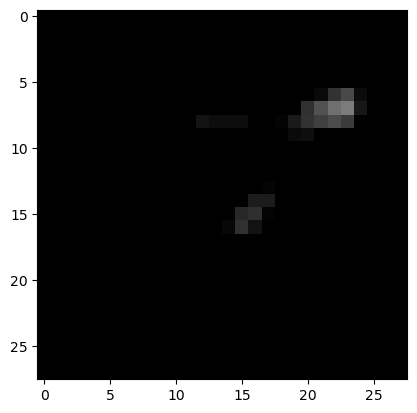

In [32]:
grid = make_grid(xh, nrow=1)
import matplotlib.pyplot as plt

plt.imshow(grid.permute(1, 2, 0).cpu().numpy())